In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np

import itertools
from sklearn import preprocessing, metrics
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, f1_score, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier

import matplotlib.pyplot as plt

In [2]:
# Random seed
random_seed = 42
def set_random_seed(seed=42):
    np.random.seed(seed)
set_random_seed(random_seed)

In [74]:
random.seed(1)

## Models definition

### LightGBM

In [4]:
import lightgbm as lgb


def train_lightgbm(train, valid, test, target_feature, n_classes):
    
    #train, valid, test = get_data_splits(df)
    
    feature_cols = train.columns.drop(target_feature)
    
    dtrain = lgb.Dataset(train[feature_cols], label=train[target_feature])
    dvalid = lgb.Dataset(valid[feature_cols], label=valid[target_feature])

    param = {'num_leaves': 64, 'objective': 'multiclass', 
             'metric': 'multi_logloss', 'num_class': n_classes, 'seed': random_seed}
    
    print("Training model!")
    bst = lgb.train(param, dtrain, num_boost_round=1000, valid_sets=[dvalid], 
                    early_stopping_rounds=10, verbose_eval=False)

    test_pred = bst.predict(test[feature_cols])
    test_pred = np.argmax(test_pred, axis=1)
    
    test_accuracy = metrics.accuracy_score(test[target_feature], test_pred)
    test_f1score = metrics.f1_score(test[target_feature], test_pred)
    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"Test f1 score: {test_f1score:.4f}")

    return bst

def train_lgbm_for_test(train, test, target_feature, n_classes):
    
    train, valid = get_train_valid_split(train)
    
    feature_cols = train.columns.drop(target_feature)

    dtrain = lgb.Dataset(train[feature_cols], label=train[target_feature])
    dvalid = lgb.Dataset(valid[feature_cols], label=valid[target_feature])

    param = {'num_leaves': 64, 'objective': 'multiclass', 
             'metric': 'multi_logloss', 'num_class': n_classes, 'seed': random_seed}
    
    print("Training model!")
    bst = lgb.train(param, dtrain, num_boost_round=1000, valid_sets=[dvalid], 
                    early_stopping_rounds=10, verbose_eval=False)
    
    test_pred = bst.predict(test)
    test_pred = np.argmax(test_pred, axis=1)
    test_pred = test_pred+1
    return test_pred

def new_features(df, cat_features):
    interactions = pd.DataFrame(index=df.index)

    # Iterate through each pair of features, combine them into interaction features
    for feature1, feature2 in itertools.combinations(cat_features, 2):
        interaction_feature = feature1+'_'+feature2
        interactions[interaction_feature] = preprocessing.LabelEncoder().fit_transform(df[feature1].apply(str)+'_'+df[feature2].apply(str))
    
    return interactions, list(interactions.columns)

### Decision Tree

In [5]:
from sklearn.tree import DecisionTreeClassifier

def train_decisiontree(X_train, X_test, y_train, y_test):

    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)

    test_pred = clf.predict(X_test)
    test_pred = np.argmax(test_pred, axis=1)
    
    # test_accuracy = metrics.accuracy_score(y_test, test_pred)
    # test_f1score = metrics.f1_score(y_test, test_pred)
    # print(f"Test accuracy: {test_accuracy:.4f}")
    # print(f"Test f1 score: {test_f1score:.4f}")

    return clf

### MLP

In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

def train_MLPClassifier(X_train, X_test, y_train, y_test):
       
    scaler = StandardScaler()
    scaler.fit(X_train)
    scaler.transform(X_train)
    scaler.transform(X_test)    
    
    print("Training model!")
    est = MLPClassifier(hidden_layer_sizes=(30, 20, 10, 10 ), activation='relu', solver='adam', alpha=0.0001, 
                       batch_size='auto', learning_rate='constant', learning_rate_init=0.001, 
                       power_t=0.5, max_iter=40, shuffle=True, random_state=None, tol=0.0001, 
                       verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, 
                       early_stopping=True, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, 
                       epsilon=1e-08, n_iter_no_change=10)
    
    est.fit(X_train, y_train)
    
    print(f"Test accuracy score: {est.score(X_test, y_test):.4f}")

    return est

#train, valid = train_test_split(X_y, 0.2)
#est = train_MLPRegressor(train, valid, 'damage_grade')

### Random Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier

def train_randomforest(X_train, X_test, y_train, y_test):

    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    test_pred = clf.predict(X_test)
    test_pred = np.argmax(test_pred, axis=1)
    
    # test_accuracy = metrics.accuracy_score(y_test, test_pred)
    # test_f1score = metrics.f1_score(y_test, test_pred)
    # print(f"Test accuracy: {test_accuracy:.4f}")
    # print(f"Test f1 score: {test_f1score:.4f}")

    return clf

## Data import and preparation

In [2]:
DATA_ROOT = '../data/processed'

In [3]:
df = pd.read_csv(f'{DATA_ROOT}/bugs-multitarget.csv')
df['priority'] = df['priority'].astype(int)
df.head()

,commitHash,inMainBranch,merge,classes,functions,commentLines,commentLinesDensity,complexity,fileComplexity,classComplexity,...,vulnerabilities,reliabilityRemediationEffort,reliabilityRating,securityRemediationEffort,securityRating,wontFixIssues,packageDependencyCycles,entropylike,added/total_lines,priority
0,e0880e263e4bf8662ba3848405200473a25dfc9f,True,False,2108,17295,13509,6.2,43137,40.6,20.4,...,838,7322,5,9505,4,0,0,1376,1.0,3
1,e0880e263e4bf8662ba3848405200473a25dfc9f,True,False,2108,17295,13509,6.2,43137,40.6,20.4,...,838,7322,5,9505,4,0,0,1376,1.0,4
2,e0880e263e4bf8662ba3848405200473a25dfc9f,True,False,2108,17295,13509,6.2,43137,40.6,20.4,...,838,7322,5,9505,4,0,0,1376,1.0,4
3,e0880e263e4bf8662ba3848405200473a25dfc9f,True,False,2108,17295,13509,6.2,43137,40.6,20.4,...,838,7322,5,9505,4,0,0,1376,1.0,5
4,e0880e263e4bf8662ba3848405200473a25dfc9f,True,False,2108,17295,13509,6.2,43137,40.6,20.4,...,838,7322,5,9505,4,0,0,1376,1.0,5


In [4]:
from sklearn.preprocessing import MultiLabelBinarizer

N_CLASSES = 6
common_cols = list(df.columns)
common_cols.remove('priority')


mlb = MultiLabelBinarizer()
df = df.groupby(common_cols)['priority'].apply(set).reset_index()
df = shuffle(df)
df['priority'] = df['priority'].to_numpy()
y_raw = df['priority']
y_raw = y_raw.to_numpy()
y_raw = [np.array(list(x)) for x in y_raw]
y = mlb.fit_transform(df['priority'])
df.drop(['commitHash', 'priority'], axis=1, inplace=True)
X = df.to_numpy()
df.head()

,inMainBranch,merge,classes,functions,commentLines,commentLinesDensity,complexity,fileComplexity,classComplexity,functionComplexity,...,newSqaleDebtRatio,vulnerabilities,reliabilityRemediationEffort,reliabilityRating,securityRemediationEffort,securityRating,wontFixIssues,packageDependencyCycles,entropylike,added/total_lines
47449,True,False,164,1099,17772,55.6,1984,12.2,12.1,1.8,...,4.128068,127,35,4,1760,4,0,0,2,0.001071
21055,True,False,440,2402,8106,27.6,4078,9.6,9.3,1.7,...,4.848456,9,270,4,110,4,0,0,1,0.000214
28485,True,False,386,3199,22779,48.3,6400,17.5,16.6,2.0,...,6.473122,57,717,5,730,4,0,0,1,0.000036
34541,True,False,454,3755,10314,23.4,7502,17.4,16.5,2.0,...,5.445882,107,617,5,1240,4,0,0,1,0.000007
49059,True,False,274,2253,16209,36.9,4428,16.5,16.2,2.0,...,3.313563,222,60,4,5440,4,0,0,1,0.000298


In [77]:
X.shape

(54622, 54)

In [5]:
X[0]

array([True, False, 164, 1099, 17772, 55.6, 1984, 12.2, 12.1, 1.8, 0,
       3796, 85, 42, 9.5, 1490, 1, 208, 11, 0, 0, 1361, 2, 0, 0, 0, 1686,
       40092, 14196, 7501, 0, 760, 510, 1490, 1, 0, 17, 17, 5618, 7501, 0,
       19168, 425880, 4.5, 4.128068091844813, 127, 35, 4, 1760, 4, 0, 0,
       2, 0.0010712894429294898], dtype=object)

In [78]:
y.shape

(54622, 6)

### Downsampling

In [79]:
nobug_idxs = []
all_idxs = []
for i, label in enumerate(y):
  all_idxs.append(i)
  if np.array_equal(label, [1, 0, 0, 0, 0, 0]):
    nobug_idxs.append(i)

print(len(nobug_idxs)/len(y))

0.9952583208231116


In [80]:
import random

D = 0.75
rm_idxs = random.sample(nobug_idxs, int(len(nobug_idxs)*D))
use_idxs = np.array(list(set(all_idxs) - set(rm_idxs)))
X = X[use_idxs]
y = y[use_idxs]


In [81]:
X.shape

(13850, 54)

In [82]:
y.shape


(13850, 6)

## Training & Evaluation

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Decision Tree

In [84]:
tree = train_decisiontree(X_train, X_test, y_train, y_test)

In [85]:
yPred = tree.predict(X_test)

In [86]:
yPred.sum(axis=0)

array([2715,    8,   37,   12,   45,   15])

In [87]:
y_test.sum(axis=0)

array([2698,    9,   35,   10,   58,   14])

### MLP

In [88]:
mlp = train_MLPClassifier(X_train, X_test, y_train, y_test)

Training model!
Test accuracy score: 0.9736


In [89]:
yPred = mlp.predict(X_test)

In [90]:
yPred.sum(axis=0)

array([2770,    0,    0,    0,    0,    0])

### Random Forest

In [91]:
rf = train_randomforest(X_train, X_test, y_train, y_test)


In [92]:
yPred = rf.predict(X_test)

In [93]:
yPred.sum(axis=0)

array([2763,    0,    4,    0,    6,    1])

## Results

In [94]:
def plot_confusion_matrix(clf, X, y):
    predY = clf.predict(X)
    cm = multilabel_confusion_matrix(y, predY)
    cms = []
    for i, m in enumerate(cm):
      cms.append(m / m.sum(axis=1)[:, np.newaxis])
      plt.subplot(len(cm)/2, 2, i+1)
      plt.tight_layout()
      plt.imshow(m / m.sum(axis=1)[:, np.newaxis])
      plt.title(f'Priority {i}')
    return cms

def get_accuracy(clf, X, y):
    accuracy = clf.score(X, y)
    print(accuracy)
    return accuracy

def get_bug_classification_accuracy(clf, X, y):
  yPreds = clf.predict(X)
  good = 0
  n = 0
  for i, yPred in enumerate(yPreds):
    for j, label in enumerate(yPred):
      if j > 0:
        n += 1
        if label == y[i, j]:
          good += 1
  acc = good / n
  print(acc)
  return acc

### Decision Tree

[array([[0.25      , 0.75      ],
        [0.01371386, 0.98628614]]), array([[0.99746469, 0.00253531],
        [0.88888889, 0.11111111]]), array([[0.99012797, 0.00987203],
        [0.71428571, 0.28571429]]), array([[0.99601449, 0.00398551],
        [0.9       , 0.1       ]]), array([[0.98783186, 0.01216814],
        [0.79310345, 0.20689655]]), array([[0.99528302, 0.00471698],
        [0.85714286, 0.14285714]])]

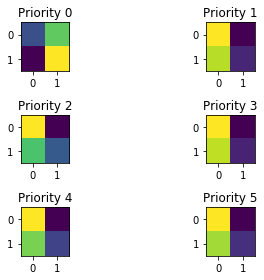

In [95]:
plot_confusion_matrix(tree, X_test, y_test)

In [96]:
get_accuracy(tree, X_test, y_test)
get_bug_classification_accuracy(tree, X_test, y_test)

0.9620938628158845
0.9862093862815885


0.9862093862815885

### MLP

[array([[0., 1.],
        [0., 1.]]), array([[1., 0.],
        [1., 0.]]), array([[1., 0.],
        [1., 0.]]), array([[1., 0.],
        [1., 0.]]), array([[1., 0.],
        [1., 0.]]), array([[1., 0.],
        [1., 0.]])]

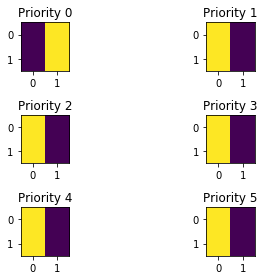

In [97]:
plot_confusion_matrix(mlp, X_test, y_test)

In [98]:
get_accuracy(mlp, X_test, y_test)
get_bug_classification_accuracy(mlp, X_test, y_test)

0.9736462093862815
0.9909025270758123


0.9909025270758123

### Random Forest

[array([[8.33333333e-02, 9.16666667e-01],
        [3.70644922e-04, 9.99629355e-01]]), array([[1., 0.],
        [1., 0.]]), array([[1.        , 0.        ],
        [0.88571429, 0.11428571]]), array([[1., 0.],
        [1., 0.]]), array([[0.99889381, 0.00110619],
        [0.94827586, 0.05172414]]), array([[9.99637155e-01, 3.62844702e-04],
        [1.00000000e+00, 0.00000000e+00]])]

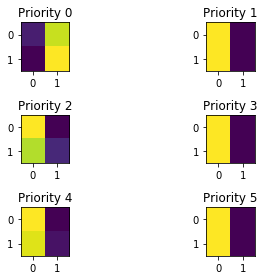

In [99]:
plot_confusion_matrix(rf, X_test, y_test)

In [100]:
get_accuracy(rf, X_test, y_test)
get_bug_classification_accuracy(rf, X_test, y_test)

0.9736462093862815
0.9911191335740073


0.9911191335740073

## Save Models

In [102]:
import pickle

In [104]:
pickle.dump(tree, open('../models/tree.sav', 'wb'))
pickle.dump(mlp, open('../models/mlp.sav', 'wb'))
pickle.dump(rf, open('../models/rf.sav', 'wb'))